In [6]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np 
import cv2
import math
import os
%matplotlib inline

In [7]:
INPUT_IMAGES_DIR = "test_images"
OUTPUT_IMAGES_DIR = "test_images_output"
INPUT_VIDEOS_DIR = "test_videos"
OUTPUT_VIDEOS_DIR = "test_videos_output"

os.listdir(INPUT_IMAGES_DIR)
os.listdir(INPUT_VIDEOS_DIR)

['solidWhiteRight.mp4', 'challenge.mp4', 'solidYellowLeft.mp4']

In [228]:

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def get_test_region_of_interest(image):
     # Next we'll create a masked edges image
    imshape = image.shape
    xsize = imshape[1]
    ysize = imshape[0]
    yoffset = 45
    xoffset = 10
    xmargin = 80
    left_bottom = (xmargin, ysize)
    left_top = (xsize/2, ysize/2 + yoffset)
    right_top = (xsize/2 + xoffset, ysize/2 + yoffset)
    right_bottom = (xsize - xmargin, ysize)
    return np.array([[
        left_bottom,
        left_top,
        right_top,
        right_bottom]], dtype=np.int32)

def draw_lines(img, lines, color=[255, 0, 0], thickness=8):
    try:
        max_left_laneline_len = 0
        max_right_laneline_len = 0
        longest_left_laneline = (0,0,0,0)
        longest_right_laneline = (0,0,0,0)

        # Pick the longest segments from each side.
        for line in lines:
            for x1,y1,x2,y2 in line:
                dy = y2 - y1
                dx = x2 - x1
                if dx == 0:
                    continue
                slope = dy / dx
                line_length = math.sqrt(dy**2 + dx**2)
                if slope < 0:
                    # Left laneline
                    if(line_length > max_left_laneline_len):
                        max_left_laneline_len = line_length
                        longest_left_laneline = line
                else:
                    # Right laneline
                    if(line_length > max_right_laneline_len):
                        max_right_laneline_len = line_length
                        longest_right_laneline = line      

        roi_vertices = get_test_region_of_interest(img)
        roi_left_bottom = roi_vertices[0][0]
        roi_left_top = roi_vertices[0][1]
        roi_right_top = roi_vertices[0][2]
        roi_right_bottom = roi_vertices[0][3]
        roi_top_line = get_line(roi_left_top, roi_right_top)
        roi_bottom_line = get_line(roi_left_bottom, roi_right_bottom)

        left_line = get_line([longest_left_laneline[0][0], longest_left_laneline[0][1]],
                             [longest_left_laneline[0][2], longest_left_laneline[0][3]])
        right_line = get_line([longest_right_laneline[0][0], longest_right_laneline[0][1]],
                              [longest_right_laneline[0][2], longest_right_laneline[0][3]])
        
        top_left_intersection_point = intersection(left_line, roi_top_line)
        bottom_left_intersection_point = intersection(left_line, roi_bottom_line)
        top_right_intersection_point = intersection(right_line, roi_top_line)
        bottom_right_intersection_point = intersection(right_line, roi_bottom_line)
        
        if top_left_intersection_point and bottom_left_intersection_point and top_right_intersection_point and bottom_right_intersection_point:     
            cv2.line(img, tuple(top_left_intersection_point), tuple(bottom_left_intersection_point), color, thickness)
            cv2.line(img, tuple(top_right_intersection_point), tuple(bottom_right_intersection_point), color, thickness)
    except TypeError:
        print("ignore TypeError")

# Method below is from : http://stackoverflow.com/a/20679579
def get_line(p1, p2):
    """Ax + By = C """
    A = (p1[1] - p2[1])
    B = (p2[0] - p1[0])
    C = (p1[0]*p2[1] - p2[0]*p1[1])
    return A, B, -C

def intersection(L1, L2):
    D  = L1[0] * L2[1] - L1[1] * L2[0]
    Dx = L1[2] * L2[1] - L1[1] * L2[2]
    Dy = L1[0] * L2[2] - L1[2] * L2[0]
    if D != 0:
        x = Dx / D
        y = Dy / D
        return (int(x),int(y))
    else:
        return False
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

# Pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.
def process_image(image):
    orig_image = np.copy(image)
    gray = grayscale(image)

    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)

     # Define our parameters for Canny and apply
    low_threshold = 50
    high_threshold = 150
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
    
    # Next we'll create a masked edges image
    roi = get_test_region_of_interest(edges)
    masked_edges = region_of_interest(edges, roi)
    
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 2
    theta = np.pi / 180
    threshold = 15
    min_line_len = 20
    max_line_gap = 15
    hough_image = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)

    weighted_image = weighted_img(hough_image, orig_image)
    return weighted_image

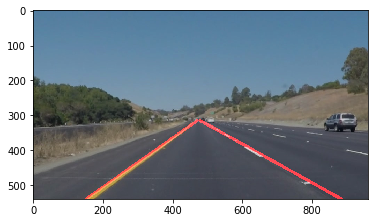

In [229]:
filename = "solidYellowCurve.jpg"
line_image = process_image(mpimg.imread(os.path.join(INPUT_IMAGES_DIR, filename)))
plt.imshow(line_image)
plt.savefig(os.path.join(OUTPUT_IMAGES_DIR, filename))

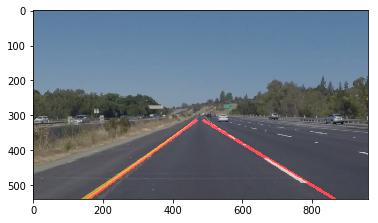

In [230]:
filename = "solidYellowLeft.jpg"
line_image = process_image(mpimg.imread(os.path.join(INPUT_IMAGES_DIR, filename)))
plt.imshow(line_image)
plt.savefig(os.path.join(OUTPUT_IMAGES_DIR, filename))

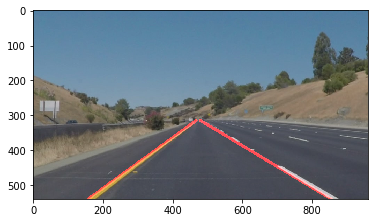

In [231]:
filename = "solidYellowCurve2.jpg"
line_image = process_image(mpimg.imread(os.path.join(INPUT_IMAGES_DIR, filename)))
plt.imshow(line_image)
plt.savefig(os.path.join(OUTPUT_IMAGES_DIR, filename))

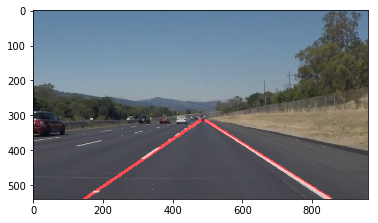

In [232]:
filename = "solidWhiteRight.jpg"
line_image = process_image(mpimg.imread(os.path.join(INPUT_IMAGES_DIR, filename)))
plt.imshow(line_image)
plt.savefig(os.path.join(OUTPUT_IMAGES_DIR, filename))

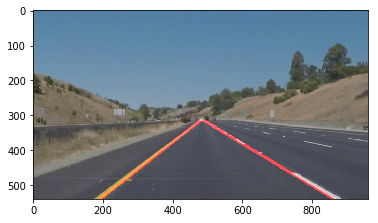

In [233]:
filename = "whiteCarLaneSwitch.jpg"
line_image = process_image(mpimg.imread(os.path.join(INPUT_IMAGES_DIR, filename)))
plt.imshow(line_image)
plt.savefig(os.path.join(OUTPUT_IMAGES_DIR, filename))

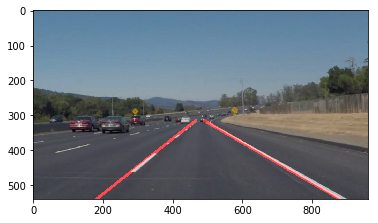

In [234]:
filename = "solidWhiteCurve.jpg"
line_image = process_image(mpimg.imread(os.path.join(INPUT_IMAGES_DIR, filename)))
plt.imshow(line_image)
plt.savefig(os.path.join(OUTPUT_IMAGES_DIR, filename))

In [235]:
# Import everything needed to edit/save/watch video clips
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [236]:
filename =  "solidWhiteRight.mp4"
clip1 = VideoFileClip(os.path.join(INPUT_VIDEOS_DIR, filename))
processed_clip = clip1.fl_image(process_image)
video_output = os.path.join(OUTPUT_VIDEOS_DIR, filename)
%time processed_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4



 89%|████████▉ | 198/222 [00:02<00:00, 75.68it/s]

ignore TypeError
ignore TypeError
ignore TypeError



100%|█████████▉| 221/222 [00:02<00:00, 75.05it/s]

ignore TypeError
ignore TypeError
ignore TypeError
ignore TypeError
ignore TypeError


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 2.37 s, sys: 522 ms, total: 2.89 s
Wall time: 3.38 s


In [238]:
filename =  "solidYellowLeft.mp4"
clip1 = VideoFileClip(os.path.join(INPUT_VIDEOS_DIR, filename))
processed_clip = clip1.fl_image(process_image)
video_output = os.path.join(OUTPUT_VIDEOS_DIR, filename)
%time processed_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4



  7%|▋         | 47/682 [00:00<00:06, 99.60it/s] 

ignore TypeError
ignore TypeError
ignore TypeError



100%|█████████▉| 681/682 [00:09<00:00, 71.30it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 7.77 s, sys: 1.55 s, total: 9.32 s
Wall time: 9.98 s


In [239]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [242]:
def get_challenge_region_of_interest(image):
     # Next we'll create a masked edges image
    imshape = image.shape
    xsize = imshape[1]
    ysize = imshape[0]
    yoffset = 100
    xmargin = 220
    left_bottom = (150, ysize)
    left_top = (xsize/2, ysize/2 + yoffset)
    right_top = (800, ysize/2 + yoffset)
    right_bottom = (xsize - xmargin, ysize)
    return np.array([[
        left_bottom,
        left_top,
        right_top,
        right_bottom]], dtype=np.int32)


def draw_lines(img, lines, color=[255, 0, 0], thickness=8):
    max_left_laneline_len = 0
    max_right_laneline_len = 0
    longest_left_laneline = (0,0,0,0)
    longest_right_laneline = (0,0,0,0)

    # Pick the longest segments from each side.
    for line in lines:
        for x1,y1,x2,y2 in line:
            dy = y2 - y1
            dx = x2 - x1
            if dx == 0:
                continue
            slope = dy / dx
            line_length = math.sqrt(dy**2 + dx**2)
            if slope < 0:
                # Left laneline
                if(line_length > max_left_laneline_len):
                    max_left_laneline_len = line_length
                    longest_left_laneline = line
            else:
                # Right laneline
                if(line_length > max_right_laneline_len):
                    max_right_laneline_len = line_length
                    longest_right_laneline = line      

    roi_vertices = get_test_region_of_interest(img)
    roi_left_bottom = roi_vertices[0][0]
    roi_left_top = roi_vertices[0][1]
    roi_right_top = roi_vertices[0][2]
    roi_right_bottom = roi_vertices[0][3]
    roi_top_line = get_line(roi_left_top, roi_right_top)
    roi_bottom_line = get_line(roi_left_bottom, roi_right_bottom)

    left_line = get_line([longest_left_laneline[0][0], longest_left_laneline[0][1]],
                         [longest_left_laneline[0][2], longest_left_laneline[0][3]])
    right_line = get_line([longest_right_laneline[0][0], longest_right_laneline[0][1]],
                          [longest_right_laneline[0][2], longest_right_laneline[0][3]])

    top_left_intersection_point = intersection(left_line, roi_top_line)
    bottom_left_intersection_point = intersection(left_line, roi_bottom_line)
    top_right_intersection_point = intersection(right_line, roi_top_line)
    bottom_right_intersection_point = intersection(right_line, roi_bottom_line)
    if top_left_intersection_point and bottom_left_intersection_point and top_right_intersection_point and bottom_right_intersection_point:
        cv2.line(img, tuple(top_left_intersection_point), tuple(bottom_left_intersection_point), color, thickness)
        cv2.line(img, tuple(top_right_intersection_point), tuple(bottom_right_intersection_point), color, thickness)


# Method below is from : http://stackoverflow.com/a/20679579
def get_line(p1, p2):
    """Ax + By = C """
    A = (p1[1] - p2[1])
    B = (p2[0] - p1[0])
    C = (p1[0]*p2[1] - p2[0]*p1[1])
    return A, B, -C

def intersection(L1, L2):
    D  = L1[0] * L2[1] - L1[1] * L2[0]
    Dx = L1[2] * L2[1] - L1[1] * L2[2]
    Dy = L1[0] * L2[2] - L1[2] * L2[0]
    if D != 0:
        x = Dx / D
        y = Dy / D
        return (int(x),int(y))
    else:
        return False

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def process_challenge_image(image):
    orig_image = np.copy(image)
    gray = grayscale(image)

    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)

     # Define our parameters for Canny and apply
    low_threshold = 50
    high_threshold = 150
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
    
    # Next we'll create a masked edges image
    roi = get_challenge_region_of_interest(edges)
    masked_edges = region_of_interest(edges, roi)
    
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 2
    theta = np.pi / 180
    threshold = 15
    min_line_len = 5
    max_line_gap = 15
    hough_image = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)

    weighted_image = weighted_img(hough_image, orig_image)
    return weighted_image

In [243]:
filename = "challenge.mp4"
clip1 = VideoFileClip(os.path.join(INPUT_VIDEOS_DIR, filename))
processed_clip = clip1.fl_image(process_challenge_image)
video_output = os.path.join(OUTPUT_VIDEOS_DIR, filename)
%time processed_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4



100%|██████████| 251/251 [00:07<00:00, 33.44it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 5.33 s, sys: 1.5 s, total: 6.82 s
Wall time: 8.37 s


In [244]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))